# Лабораторна робота 5

Романенко Ілля ФІТ 4-7

23 варіант

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Завдання 1

## Крок 1

Завантажимо датасет Cilifornia Housing, та розділимо його на навчальну та тестову вибірку.

Попередній аналіз датасету ми проводили раніше в минулих лабораторних, тому проводити його знову не будемо

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data = fetch_california_housing()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Крок 2

Побудуємо регресійну модель

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_train_pred = lin_model.predict(X_train)
y_test_pred = lin_model.predict(X_test)

lin_train_mse = mean_squared_error(y_train, y_train_pred)
lin_test_mse = mean_squared_error(y_test, y_test_pred)
lin_train_r2 = r2_score(y_train, y_train_pred)
lin_test_r2 = r2_score(y_test, y_test_pred)

print(f'TRAIN MSE: {lin_train_mse:.2f} R2: {lin_test_mse:.2f}')
print(f'TEST MSE: {lin_test_mse:.2f} R2: {lin_test_r2:.2f}')

TRAIN MSE: 0.52 R2: 0.56
TEST MSE: 0.56 R2: 0.58


схоже що натренована модель себе показує навіть краще на тестовій вибірці, ніж на тренувальній, що може свідчити про відсутність значного перенавчання

## Крок 3

запобігання перенавчання

In [4]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

alphas =  np.logspace(-5, 10, 50)

ridge_cv_scores = []
for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    scores = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    ridge_cv_scores.append(-scores.mean())

best_ridge_alpha = alphas[np.argmin(ridge_cv_scores)]

print(f'Ridge alpha: {best_ridge_alpha}')

Ridge alpha: 6.551285568595509


In [5]:
from sklearn.linear_model import Lasso

lasso_cv_scores = []
for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train, y_train)
    scores = cross_val_score(lasso_model, X, y, cv=5, scoring='neg_mean_squared_error')
    lasso_cv_scores.append(-scores.mean())

best_lasso_alpha = alphas[np.argmin(lasso_cv_scores)]

print(f'Lasso alpha: {best_lasso_alpha}')

Lasso alpha: 0.0006866488450042998


In [6]:
ridge_model = Ridge(alpha=best_ridge_alpha)
ridge_model.fit(X_train, y_train)
ridge_y_test_pred = ridge_model.predict(X_test)

lasso_model = Lasso(alpha=best_lasso_alpha)
lasso_model.fit(X_train, y_train)
lasso_y_test_pred = lasso_model.predict(X_test)

ridge_test_mse = mean_squared_error(y_test, ridge_y_test_pred)
lasso_test_mse = mean_squared_error(y_test, lasso_y_test_pred)
ridge_test_r2 = r2_score(y_test, ridge_y_test_pred)
lasso_test_r2 = r2_score(y_test, lasso_y_test_pred)

print(f"Ridge MSE = {ridge_test_mse:.2f} R^2 = {ridge_test_r2:.2f}")
print(f"Lasso MSE = {lasso_test_mse:.2f} R^2 = {lasso_test_r2:.2f}")

Ridge MSE = 0.56 R^2 = 0.58
Lasso MSE = 0.55 R^2 = 0.58


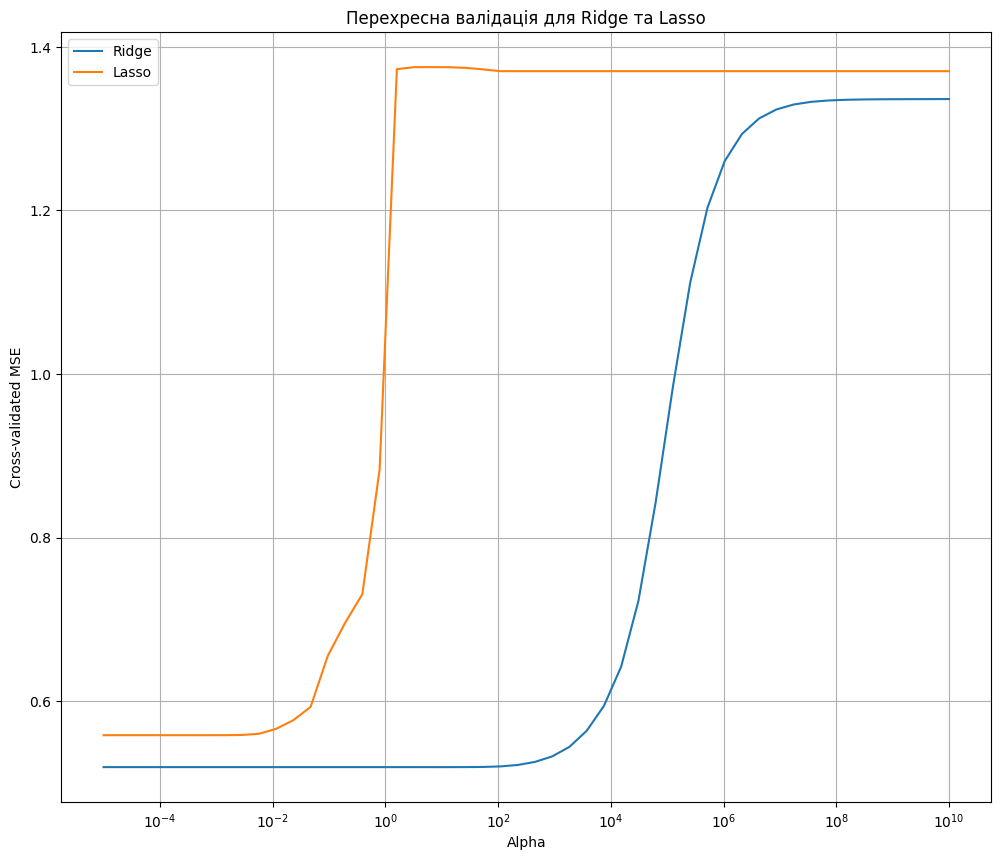

In [7]:
plt.figure(figsize=(12, 10))
plt.semilogx(alphas, ridge_cv_scores, label='Ridge')
plt.semilogx(alphas, lasso_cv_scores, label='Lasso')
plt.xlabel('Alpha')
plt.ylabel('Cross-validated MSE')
plt.title('Перехресна валідація для Ridge та Lasso')
plt.legend()
plt.grid(True)
plt.show()

### Висновки

Загалом, регуляризація трохи допомогла покращити продуктивність моделі, зменшивши перенавчання та MSE. Проте загалом зі збільшенням значення alpha продуктивність Ridge та Lasso дещо погіршується. При цьому модель Ridge показує більш задовільний результат ніж Lasso, бо є більш стабільною та менш чутливою до великих значень alpha

# Завдання 2

## Крок 1


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_2d = pd.DataFrame(X_scaled, columns=data.feature_names).iloc[:, 1:]

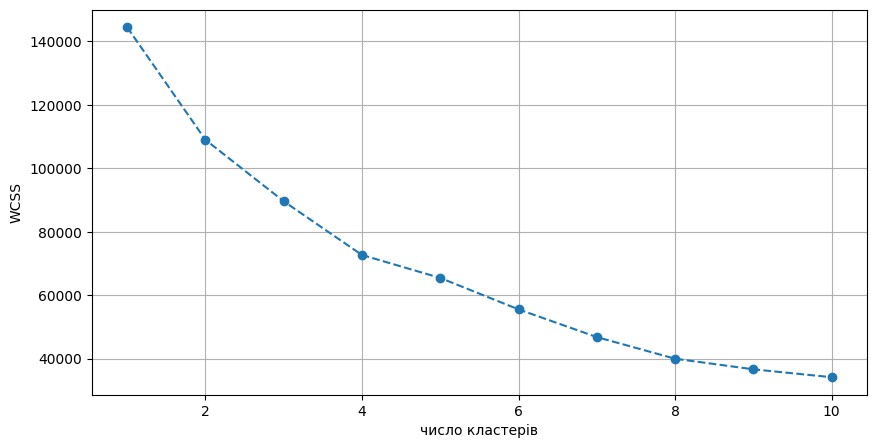

In [12]:
from sklearn.cluster import KMeans

wcss_2d = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10, random_state=42)
    kmeans.fit(x_2d)
    wcss_2d.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss_2d, marker='o', linestyle='--')
plt.xlabel('число кластерів')
plt.ylabel('WCSS')
plt.grid()
plt.show()

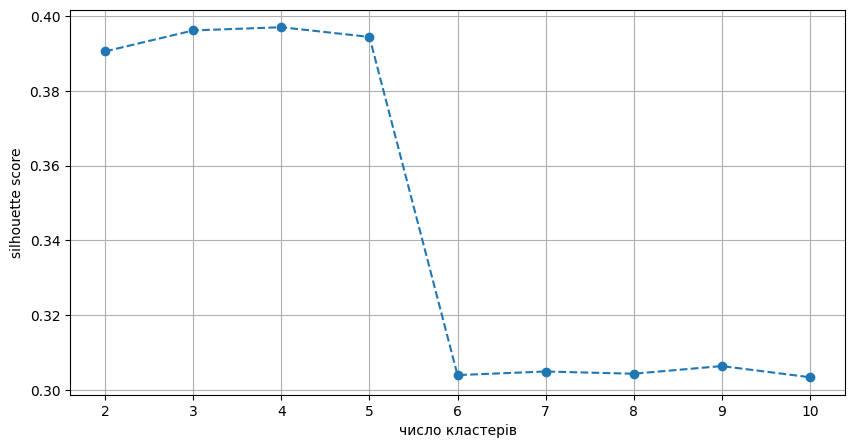

In [13]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10, random_state=42)
    cluster_labeles = kmeans.fit(x_2d)
    silhouette_scores.append(silhouette_score(x_2d, kmeans.labels_))


plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('число кластерів')
plt.ylabel('silhouette score')
plt.grid()
plt.show()

Отже для загальної кластеризації данних, буде доцільно розділити їх на 5 кластерів

## Крок 2

Візуалізуємо загальну кластеризацію за всіма ознаками

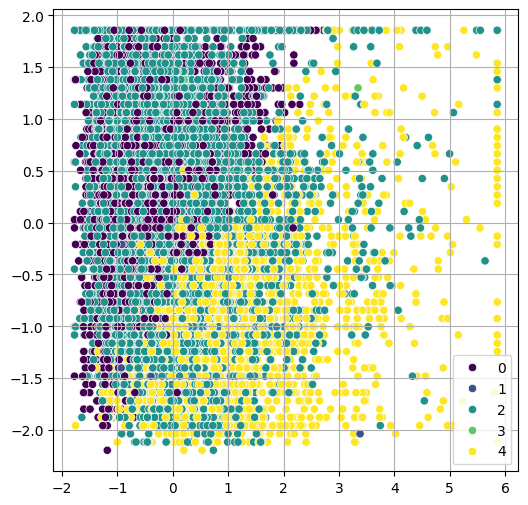

In [17]:
kMeans = KMeans(n_clusters=5, init='k-means++', max_iter=5000, n_init=100, random_state=42)
clusters = kMeans.fit_predict(X_scaled)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=clusters, palette='viridis', legend='full')
plt.grid()
plt.show()

Візуалізуємо кластеризацю даних, використовуючи данні про географічне положення будинків, тобто на основі даних про широту та довготу

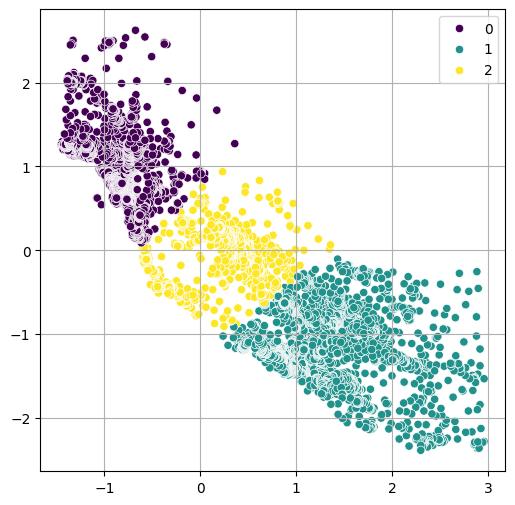

In [21]:
latitude_longitude = X_scaled[:, [6, 7]] # широта та довгота

kMeans = KMeans(n_clusters=3, init='k-means++', max_iter=5000, n_init=100, random_state=42)
clusters = kMeans.fit_predict(latitude_longitude)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=latitude_longitude[:, 0], y=latitude_longitude[:, 1], hue=clusters, palette='viridis', legend='full')
plt.grid()
plt.show()

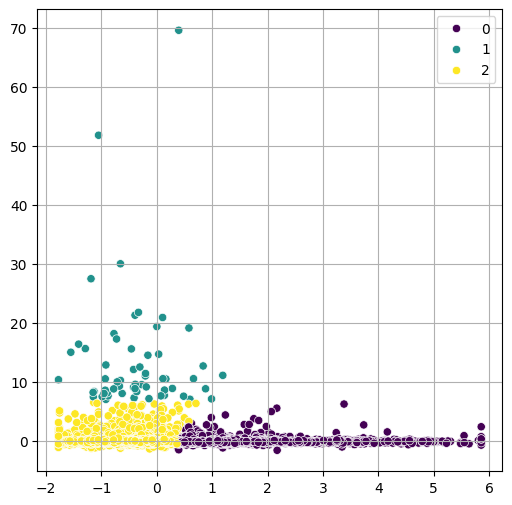

In [22]:
latitude_longitude = X_scaled[:, [0, 3]] # дохід та кількість кімнат

kMeans = KMeans(n_clusters=3, init='k-means++', max_iter=5000, n_init=100, random_state=42)
clusters = kMeans.fit_predict(latitude_longitude)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=latitude_longitude[:, 0], y=latitude_longitude[:, 1], hue=clusters, palette='viridis', legend='full')
plt.grid()
plt.show()

## Висновки

На основі даних про житло в каліфорнії, ми змогли кластеризувати дані, як загалом, так і за окремими стовпцями даних. В окремих випадках можемо чітко простежувати відмежування кластерів один від одного, в інших випадках різниця не настільки помітна.